# Machine Learning to Identify Beer by Label - The Twelve Pack

Six-Pick is a phone app that will be able to classify a beer by its label, as well as provide information about the beer such as the brewery, ingredients, and flavor profile. This concept program, The Twelve Pack, will demonstrate the potential of the app by classifying pictures of twelve beers and connecting to the [BreweryDB API](https://www.brewerydb.com/) to provide information about each beer. 

This concept program will utilize SciKit Learn, Tensorflow and Keras for the machine learning model, as well as OpenCV for image manipulation. Furthermore, Matplotlib, Pandas and Numpy will provide the backbone of visulazation and data organization/exploration. A convolutional neural network (CNN) and a Random Forest Classifier (RFC) will be used to classify the beer labels.  

500 pictures were taken of each beer an iPhone 8, 250 in full lighting and 250 in dark lighting. The photos were then uploaded to a 1TB 'WD My Passport for Mac' external hard drive. The iPhone saves photos in the HEIC format, so all pictures were converted to jpg using the Automator app on a 2018 Macbook Pro. 

The reason this method was used to provide the data is that the Six-Pic app would run on pictures taken from a smart phone. The reason for the different lighting is that pictures used in the app will likely be taken outside in a well-lit environment, or in a bar/brewery in a poorly-lit environment. 

In order to train the model effectively, altered images will be created from the original images for each beer using the Keras ImageDataGenerator. This method will save time during data collection (less pictures will need to be taken) and automate the image generation process. 

## Types of Beer Used in Model and The Vessel

1) Stone Delicious IPA - Bottle

2) Allagash White Belgian Ale - Bottle

3) Alpine Duet - Bottle

4) Aurora Hoppyalis - Bottle

5) Ballast Point California Kolsch - Bottle

6) Bear Republic Racer 5 - Bottle

7) Sierra Nevada Pale Ale - Bottle

8) Green Flash West Coast IPA - Bottle

9) Lagunitas Secret Agenda - Bottle

10) Pizza Port Swami's IPA - Can

11) Coronado Mermaid's Republic - Can

12) Modern Times Orderville - Can

## Data Loading and Wrangling

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
%matplotlib inline
# import cv2 for image shaping
import cv2
# import tensorflow
import tensorflow as tf
# import keras
import keras
# import data generator
from keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers, optimizers
from keras.optimizers import RMSprop
# Import the backend
from keras import backend as K
# import callbacks and f1 score necessities
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
# import random forest for second model test
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# import classification report for categorical analysis
from sklearn.metrics import classification_report
# import learning curve to visualize random forest
from sklearn.model_selection import learning_curve

Using TensorFlow backend.


First, the original images will be loaded from the external drive:

In [2]:
# declare number of types of beer
num_classes = 12
# declare path to external hard drive where photos are stored
base_path = r'/Volumes/My Passport for Mac/run_images'
# define function to get jpgs from path
def get_img(path):
    # create empty list to store jpgs
    all_jpgs = []
    for root, dirs, files in os.walk(path, topdown=True):
        for jpg in files:
            _, ext = os.path.splitext(jpg)
            if ext == '.jpg':
                all_jpgs.append(os.path.join(root, jpg))
            elif ext == '.jpeg':
                all_jpgs.append(os.path.join(root, jpg))
    return all_jpgs

# define function to extract beer name from filenames
def get_labels(path):
    path_list = []
    storage = []
    # iterate through jpeg files for generated images and extract beer names
    for root, dirs, files in os.walk(path, topdown=True):
        for file in files:
            path_list.append(file)
            parts = file.split('_')
            l = parts[0] + '_' + parts[1]
            # drop .DS_Store value from external hard drive
            if l == '.DS_Store':
                None
            else:
                storage.append(l)
    return storage

# call function to get jpgs
all_imgs = get_img(base_path)
# get labels from image names
labels = get_labels(base_path)

A pandas dataframe will be created from the image jpg files and the labels.

In [3]:
# create pandas frame from lists
df = pd.DataFrame({'images': all_imgs, 'labels': labels})
# shuffle rows to eliminate bias from image groupings
df = df.sample(frac=1)
# reindex dataframe 
df = df.reset_index()
df = df.drop(['index'], 1)
# show format
df.head()

,images,labels
0,/Volumes/My Passport for Mac/run_images/laguni...,lagunitas_secretagenda
1,/Volumes/My Passport for Mac/run_images/corona...,coronado_mermaidsred
2,/Volumes/My Passport for Mac/run_images/pizzap...,pizzaport_swamisipa
3,/Volumes/My Passport for Mac/run_images/sierra...,sierranevada_paleale
4,/Volumes/My Passport for Mac/run_images/allaga...,allagash_white


## Data Exploration

The image shape is (4032, 3024, 3)
Minimum RGB value in this image 0
The aspect ratio of the image is 0.75


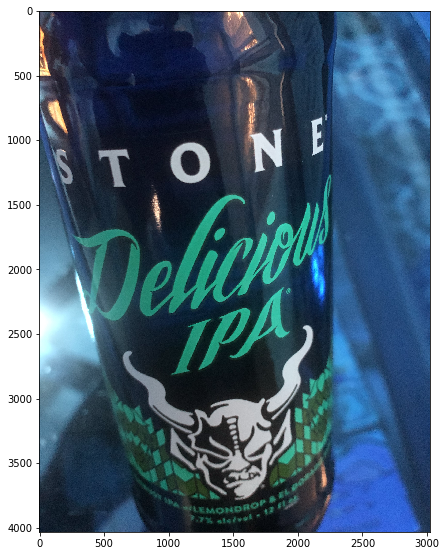

In [4]:
# show sample image with opencv
im_path = r'/Volumes/My Passport for Mac/original_pics/stone_delicious/stone_delicious_4898.jpg'
img = cv2.imread(im_path)
height, width, channels = img.shape
plt.figure(figsize=(7,10))
plt.imshow(img)
print('The image shape is {}'.format(img.shape))
print('Minimum RGB value in this image {}'.format(img.min()))
print('The aspect ratio of the image is {}'.format(width/height))

The first two dimensions of the image shape are the height and width, while the third is the number of channels for the image. The image has a height of 4032 and a width of 3024, the resolution on the iPhone 8, and 3 channels. A 3 channel image is color (one channel each for red, green and blue or RGB) and a 1 channel image is a black and white or gray image. 

The minimum RGB value for the image is 0, showing that the images can be resized to any dimension for modeling. Since the aspect ration is 0.75, this ratio will be maintained for any resized images. 

Since the images used in this report are taken in color (and the model should be tested on color images), the 3 channel images will be used. Below the blue, green, and red channels will be shown on the same image. The code for this display is borrowed from [Mohammed Innat.](https://www.kdnuggets.com/2018/07/basic-image-data-analysis-numpy-opencv-p1.html) 

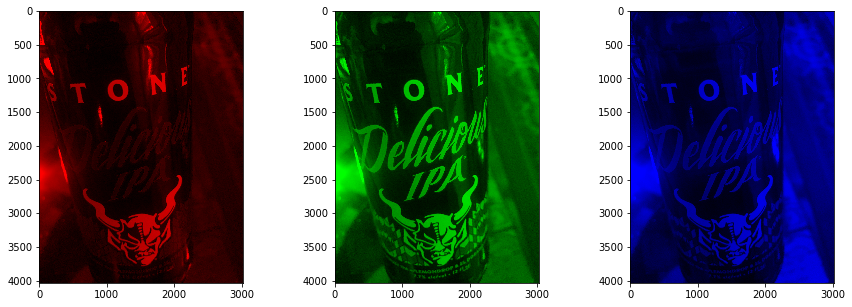

In [5]:
# show 3 pictures of same image, one for each color channel
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5)) 
for c,ax in zip(range(3),ax): 
    # create zero matrix
    split_img=np.zeros(img.shape,dtype="uint8")# 'dtype' by default: 'numpy.float64' 
    # assigning each channel 
    split_img[:,:,c]=img[:,:,c]
    # display each channel
    ax.imshow(split_img)

In the next section of the report all images will be converted to smaller images for the model. To show how the larger and smaller images differ, the image above will be converted to a (200, 150, 3) shape and shown.

The image shape is (200, 150, 3)
Minimum RGB value in this image 0
The aspect ratio of the image is 0.75


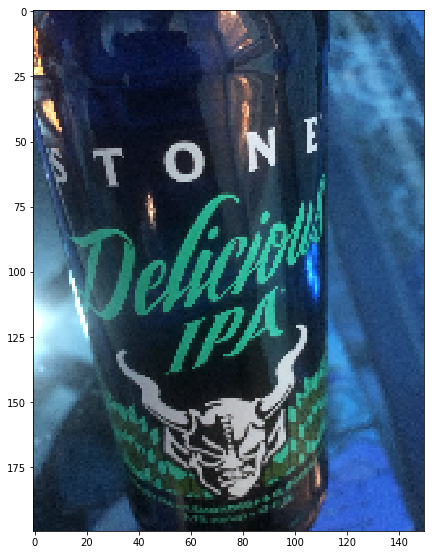

In [6]:
def resize_img(path):
    # read color photos
    im = cv2.imread(path)
    # resize images to save computational power and ensure same size across all images while maintaining aspect
    ## ratio
    resized_img = cv2.resize(im, (150, 200))
    height, width, channels = resized_img.shape
    return resized_img
# resize image
r_img = resize_img(im_path)
plt.figure(figsize=(7,10))
plt.imshow(r_img)
print('The image shape is {}'.format(r_img.shape))
print('Minimum RGB value in this image {}'.format(r_img.min()))
print('The aspect ratio of the image is {}'.format(width/height))

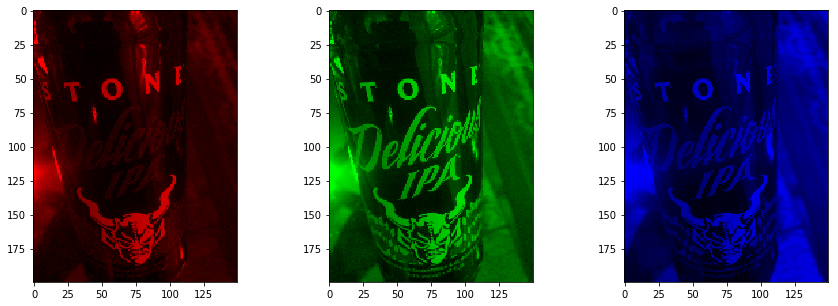

In [7]:
# show 3 pictures of same image, one for each color channel
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5)) 
for c,ax in zip(range(3),ax): 
    # create zero matrix
    split_img=np.zeros(r_img.shape,dtype="uint8")# 'dtype' by default: 'numpy.float64' 
    # assigning each channel 
    split_img[:,:,c]=r_img[:,:,c]
    # display each channel
    ax.imshow(split_img)

# Convolutional Neural Network to Predict Beer by Label

A [convolutional neural network (CNN)](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5) from Keras will be used to classify the images. This model mutiplies the matrix values of an image with a kernel. This kernel acts like a magnifiying glass as a small neural network layer that lies on top of the larger image array layer. The smaller layer analzyes all pixels in the image array, much like a magnifying glass moving over a page.   

New arrays will be created from the generated images, the labels will be assigned, and then the test and training sets created. Before the model is created, how can the model output the name of the beer instead of a dummy variable or keras one-hot-encoding array?

## Prepare Data for Model

In order to properly label each category, the label for the test set will be converted to category codes and a dictionary pairing the numbers to the labels will be created. 

First, a column called 'cats' will be added to the dataframe. This will act as the response variable for the model.

In [8]:
# create test_labels list
cat_labels = df['labels'].astype('category').cat.codes
# concatenate back onto original dataframe
df = pd.concat([df, cat_labels], 1)
# rename concatenated column
df = df.rename(columns={0: 'cats'})
# convert cats columns to string for keras
df['cats'] = df['cats'].astype(str)

A dictionary will then be created from the cats column of the frame. This will allow the generators to be created with proper labeling that will match with the string name of each beer through the dictionary. 

In [9]:
# create dictionary for values in test_labels
dict_labels = dict( zip(df['cats'], df['labels']))
# create list of labels for cnn
model_labels = list(dict_labels.keys())
# show dictionary
dict_labels

{'7': 'lagunitas_secretagenda',
 '5': 'coronado_mermaidsred',
 '9': 'pizzaport_swamisipa',
 '10': 'sierranevada_paleale',
 '0': 'allagash_white',
 '1': 'alpine_duet',
 '4': 'bearrepublic_racer5',
 '6': 'greenflash_westcoastipa',
 '11': 'stone_delicious',
 '3': 'ballastpoint_californiakolsch',
 '2': 'aurora_hoppyalis',
 '8': 'moderntimes_orderville'}

To ensure all labels are in the training, test and validation sets (the training set will be 60% of the total data, test 20%, and the validation 20%), the sets will be created and the number of labels in each set shown. 

In [10]:
# create test, training, and validation sets
train = df[:3600]
test = df[3600:4800]
valid = df[4800:]
# show the number of labels in each set
print('There are {} labels in the training set'.format(len(train['cats'].unique())))
print('There are {} labels in the test set'.format(len(test['cats'].unique())))
print('There are {} labels in the validation set'.format(len(valid['cats'].unique())))

There are 12 labels in the training set
There are 12 labels in the test set
There are 12 labels in the validation set


Then a list of labels for each model set will be created.

In [11]:
# create labels for test, training and validation sets
train_labels = train['cats']
test_labels = test['cats']
valid_labels = valid['cats']

## Image Generation

The [Keras ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) is a powerful tool that allows the user to generate 'altered' images in order to create more data to train a machine learning model. The code used to create the generators and CNN model is borrowed from [Vijayabhaskar J.](https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24) 

The target size of the image will be changed to (200, 150) as smaller images will allow the model to run faster while keeping the aspect ratio the same. The generator will also create altered images to train the model. 

In [56]:
# declare batch size
batch_size=32
# declare traind and test datagen
datagen=ImageDataGenerator(rescale=1./255., horizontal_flip = True, vertical_flip = False,  
                           width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, 
                           rotation_range = 10, shear_range=0.2, fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255.)

# build train datagenerator 
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=base_path,
x_col='images',
y_col='cats',
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode='categorical',
classes=model_labels,
target_size=(200, 150))

# build validation generator
valid_generator=test_datagen.flow_from_dataframe(
dataframe=valid,
directory=base_path,
x_col='images',
y_col='cats',
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode='categorical',
classes=model_labels,
target_size=(200, 150))

# build test generator
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory=base_path,
x_col='images',
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200, 150))

Found 3600 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 1200 images.


## Compile the CNN Model

The model used to classify the labels is borrowed from the [Thinkful curriculum.](https://courses.thinkful.com/data-201v1/assignment/6.6.5)

In [13]:
# build the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(200, 150, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# compile
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['categorical_accuracy'])
# show summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 73, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 73, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 457856)            0         
_________________________________________________________________
dense_1 (Dense)      

In [14]:
# size all generators and fit model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
112/112 [==============================] - 1612s 14s/step - loss: 2.4449 - categorical_accuracy: 0.2218 - val_loss: 1.7542 - val_categorical_accuracy: 0.5134
Epoch 2/15
112/112 [==============================] - 1915s 17s/step - loss: 1.6446 - categorical_accuracy: 0.4581 - val_loss: 1.2280 - val_categorical_accuracy: 0.6087
Epoch 3/15
112/112 [==============================] - 2227s 20s/step - loss: 1.2264 - categorical_accuracy: 0.5879 - val_loss: 0.6123 - val_categorical_accuracy: 0.7988
Epoch 4/15
112/112 [==============================] - 1814s 16s/step - loss: 0.9108 - categorical_accuracy: 0.6961 - val_loss: 0.4321 - val_categorical_accuracy: 0.8781
Epoch 5/15
112/112 [==============================] - 1472s 13s/step - loss: 0.7505 - categorical_accuracy: 0.7497 - val_loss: 0.2211 - val_categorical_accuracy: 0.9437
Epoch 6/15
112/112 [==============================] - 1402s 13s/step - loss: 0.5829 - categorical_accuracy:

Keras allows models to be saved for later use:

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("model_twelvepack.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_twelvepack.h5")
print("Saved model to disk")

Saved model to disk


## CNN Model Analysis

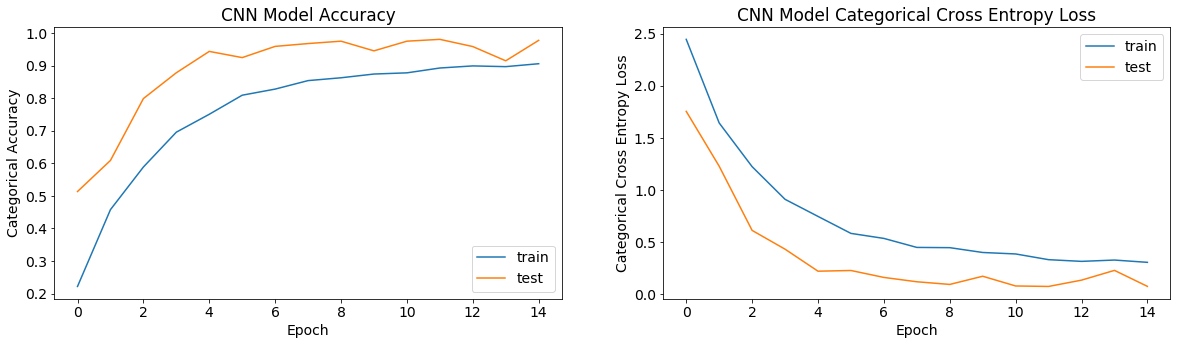

In [16]:
# declare font dictionary so plots are easier to read
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
# apply dictionary to plots
plt.rc('font', **font)
# create frames for plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
# summarize history for categorical accuracy
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('CNN Model Accuracy')
ax1.set_ylabel('Categorical Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'test'], loc='lower right')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('CNN Model Categorical Cross Entropy Loss')
ax2.set_ylabel('Categorical Cross Entropy Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'test'], loc='upper right')
plt.show()

The plots for model accruacy and catgeorical cros entropy loss show that the model is stable as the train and test sets increase in accuracy and decrease in loss. The model also has about 91% accuracy when predicting the beer by label, with 98% when predicting the validation set.   

# Random Forest Classifier to Predict Beer by Label

[Sklearn's Random Forest Classifier (RFC)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) will be used to classify the beer by label as a second model test. This model will be compared to the CNN, and advantages and disadvantages will be discussed below. A random forest act like a black box, meaning the model parameteres are hidden by design, but model analysis such as scoring plots will be shown.  

In order to run the random forest model, all images will first be converted to a list of arrays by train, test and validation sets using the get_imgs function declared above. The arrays and label sets will then be reshaped to fit the random forest model, using code provided by [Hyperion Development](https://blog.hyperiondev.com/index.php/2019/02/18/machine-learning/).  

In [17]:
# define function to resize images in image sets and convert to a normalized array of arrays
def get_arrays(data):
    all_pics = []
    all_arrs = []
    jpgs = []
    for jpg in data:
        jpgs.append(jpg)
    for jpg in jpgs:
        # read color photos
        im = cv2.imread(jpg)
        # resize images to save computational power and ensure same size across all images while maintaining aspect
        ## ratio
        resized_img = cv2.resize(im, (150, 200))
        all_pics.append(resized_img)
        # convert list to array
        all_arrs = np.asarray(all_pics)
        img_width, img_height = 150, 200
        # reshape test and train arrays for keras, the code here will remain in case other channel types are used
        ## in the future
        if K.image_data_format() == 'channels_first':
            all_arrs = all_arrs.reshape(all_arrs.shape[0], 3, img_height, img_width)
            input_shape = (3, img_height, img_width)
        else:
            all_arrs = all_arrs.reshape(all_arrs.shape[0], img_height, img_width, 3)
            input_shape = (img_height, img_width, 3)
        # normalize images
        all_arrs = all_arrs.astype('float32')
        all_arrs /= 255
    return all_arr
# call get_arrays function on training and validation sets, train already collected above
train_arrs = get_arrays(train['images'])
test_arrs = get_arrays(test['images'])
valid_arrs = get_arrays(valid['images'])

The RFC model only works with 2-dimensional arrays, so the arrays for each set will be transformed.  

In [18]:
# reshape arrays for random forest
X_train = train_arrs.reshape(train_arrs.shape[0],train_arrs.shape[1]*train_arrs.shape[2]*train_arrs.shape[3])
X_test = test_arrs.reshape(test_arrs.shape[0],test_arrs.shape[1]*test_arrs.shape[2]*test_arrs.shape[3])
val = valid_arrs.reshape(valid_arrs.shape[0],valid_arrs.shape[1]*valid_arrs.shape[2]*valid_arrs.shape[3])
y_train = np.asarray(train_labels)
y_train = y_train.reshape(y_train.shape[0],)
y_test = np.asarray(test_labels)
y_test = y_test.reshape(y_test.shape[0],)
val_test = np.asarray(valid_labels)
val_test = val_test.reshape(valid_labels.shape[0],)

Next the model will be fit using sklearn's [model selection learning curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) and code provided by [Chris Albion](https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/). 

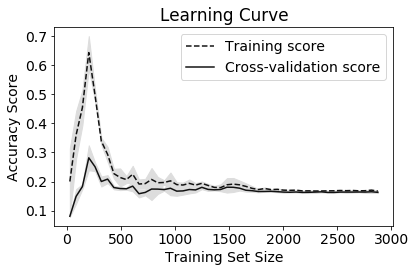

The RFC model is 0.19666666666666666% accurate.


In [19]:
# declare RFC model parameters
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=64, 
                             max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.2, 
                             min_impurity_split=None, min_samples_leaf=1, min_samples_split=50, 
                             min_weight_fraction_leaf=0.2, n_jobs=4, oob_score=True, 
                             random_state=None, verbose=0, warm_start=False, n_estimators=500)
# set learning curve on training data
train_sizes, train_scores, test_scores = learning_curve(rfc, 
                                                        X_train, 
                                                        y_train,
                                                        cv=5,
                                                        scoring='accuracy',
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
# create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# plot bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# plot information
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()
# get accuracy score on validation set
rfc.fit(val, val_test)
print('The RFC model is {}% accurate.'.format(rfc.score(val, val_test).mean()*100))

This model is much less accurate than the CNN model, likely because neural networks are better suited to classify images. Also, since the image arrays need to be converted to two dimensional arrays for the RFC, some information may have been lost in the conversion process.

The accuracy of the RFC model is does not show promising results. For these reasons, the CNN Model will be used in further testing. 

# CNN Model Test

Now the model will be tested on an image of Racer 5 from the internet, and an API call to BreweryDB will be initiated to receive information on the beer.

The image shape is (4032, 3024, 3)
Minimum RGB value in this image 0
The aspect ratio of the image is 0.75


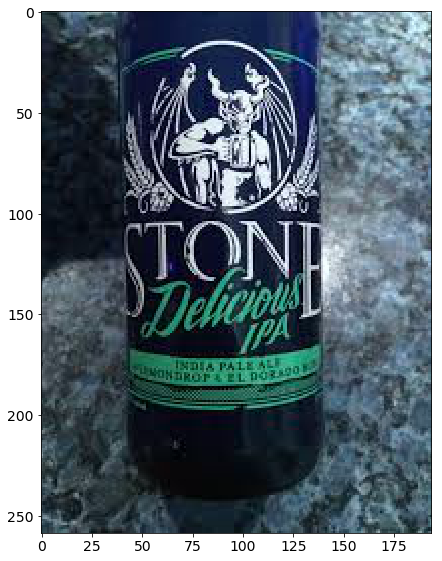

In [44]:
# show sample image with opencv
im_path = r'/Users/kyleknoebel/Desktop/download.jpeg'
new_img = cv2.imread(im_path)
height, width, channels = img.shape
plt.figure(figsize=(7,10))
plt.imshow(new_img)
print('The image shape is {}'.format(img.shape))
print('Minimum RGB value in this image {}'.format(img.min()))
print('The aspect ratio of the image is {}'.format(width/height))

In [45]:
# define function to load image
def get_beer_web(image):
    all_pics = []
    all_arrs = []
    all_pics.append(image)
    # convert list to array
    all_arrs = np.asarray(all_pics)
    img_width, img_height = 200, 150
    # reshape test and train arrays for keras, the code here will remain in case other channel types are used
    ## in the future
    if K.image_data_format() == 'channels_first':
        all_arrs = all_arrs.reshape(all_arrs.shape[0], 3, img_width, img_height)
        input_shape = (3, img_width, img_height)
    else:
        all_arrs = all_arrs.reshape(all_arrs.shape[0], img_width, img_height, 3)
        input_shape = (img_width, img_height, 3)
    # normalize images
    all_arrs = all_arrs.astype('float32')
    all_arrs /= 255
    return all_arrs

# define function to predict beer label from image arrays
def get_beer(arrs):
    label = model.predict_classes(arrs)
    for k, v in dict_labels.items():
        # convert label to string
        if k == label.astype(str):
            return v

In [46]:
import json
# resize test image
test_img = resize_img(im_path)
# get arrays of image
img_arrs = get_beer_web(test_img)
# predict beer using CNN model
beer = get_beer(img_arrs)
print('The model returned: {}'.format(beer))

The model returned: stone_delicious


In [51]:
import urllib
# declare api key
key = 'd5f2bab500facc767e336b3298151e79'
# empty list of urls
urls = []
# iterate through list of beers and get info
urls.append('https://api.brewerydb.com/v2/search?key={}&q={}'.format(key, beer))
for site in urls:
    with urllib.request.urlopen(site) as url:
        # Read the JSON
        data = json.loads(url.read().decode())

In [55]:
# show output of api call
data

{'currentPage': 1,
 'numberOfPages': 10,
 'totalResults': 483,
 'data': [{'id': 'xjPpWf',
   'name': 'Suspicious Delicious',
   'nameDisplay': 'Suspicious Delicious',
   'description': '100% Brett fermented Oak Aged Amber Saison',
   'abv': '6.9',
   'styleId': 132,
   'isOrganic': 'N',
   'isRetired': 'N',
   'status': 'verified',
   'statusDisplay': 'Verified',
   'createDate': '2016-05-10 17:01:42',
   'updateDate': '2016-05-12 12:21:10',
   'style': {'id': 132,
    'categoryId': 11,
    'category': {'id': 11,
     'name': 'Hybrid/mixed Beer',
     'createDate': '2012-03-21 20:06:46'},
    'name': 'Wood- and Barrel-Aged Beer',
    'shortName': 'BBL Aged',
    'description': 'A wood- or barrel-aged beer is any lager, ale or hybrid beer, either a traditional style or a unique experimental beer that has been aged for a period of time in a wooden barrel or in contact with wood. This beer is aged with the intention of imparting the particularly unique character of the wood and/or what ha

Stone delicious does not show in the API call, but Stone as a brewery does.  

# Summary

Overall, the model shows comendable accuracy when predicting beers by labels of the twelve selected. The CNN model is the better option for this project, as it has better accuracy and can be saved for later use. How well does the CNN model predict the label in the unused test set?  

The beers chosen for this report are from smaller, craft breweries. As such, many of the beers and the breweries themselves do not seem to be showing up in BreweryDB's API yet. More work should be done to get better results from the API, but the output shows that retrieving ingredients, styles, and flavor profile is possible.

In [60]:
# show correlation between the predicted and true labels
y_true = test['cats'].astype(int)
y_pred = model.predict_classes(test_arrs)
df_corr = pd.DataFrame({'True Labels': y_true, 'Predicted Labels': y_pred})
print('The correlation between the sets is {}%.'.format(df_corr['True Labels'].corr(df_corr['Predicted Labels'])*100))

The correlation between the sets is 13.405231017895202%.


As of this report, the model only works when predicting high resolution images from the Internet, similar to iPhone images. These images are what the report is designed to work on, but the model can still be improved with some tweaks. To improve the model:

- more pictures should be taken of all beers to better train the model
- the model itself should be added to (creating more layers for example)
- the model should be trained on beers that are popular on BreweryDB so the API call works better

The reason these changes were not made here is that this report is due to a lack of time. 